In [1]:
import os
import sys
directory_path = os.path.abspath(os.path.join('..'))
if directory_path not in sys.path:
    sys.path.append(directory_path)
os.chdir(directory_path)
from time import time
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option("display.max_columns", 30)
import numpy as np
# libraries for visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="white")
from collections import Counter
from time import time
# Set some Pandas options
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 25)
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline') 
get_ipython().magic(u"config InlineBackend.figure_format='retina'")
import seaborn as sns
# Library's to apply balance technic's
from imblearn.under_sampling import RandomUnderSampler
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler,Normalizer,RobustScaler
from sklearn.compose import make_column_transformer

In [2]:
def create_variables(data):
    # create the variable of number of flights in origin by date operated and merge it with the database
    aux = data.groupby(['fecha_operacion'])['Ori-O'].count().reset_index().sort_values(by='Ori-O')
    aux.rename(columns={'Ori-O':'NVuelos-Ori-O'}, inplace=True)
    data = pd.merge(data, aux, on = ['fecha_operacion'], how='left')

    # create the variable of number of flights in origin by date scheduled and merge it with the database
    aux = data.groupby(['fecha_operacion'])['Ori-I'].count().reset_index().sort_values(by='Ori-I')
    aux.rename(columns={'Ori-I':'NVuelos-Ori-I'}, inplace=True)
    data = pd.merge(data, aux, on = ['fecha_operacion'], how='left')

    # create the variable of number of flights in destiny scheduled by date and airline scheduled
    aux = data.groupby(['fecha_operacion','Emp-I'])['Ori-I'].count().reset_index().sort_values(by='Ori-I')
    aux.rename(columns={'Ori-I':'Nvuelos-Fecha-Emp-I'}, inplace=True)
    data = pd.merge(data, aux, on = ['fecha_operacion','Emp-I'], how='left')

    # create the variable of number of flights in by date and airline who operated it
    aux = data.groupby(['fecha_operacion','Emp-O'])['Ori-O'].count().reset_index().sort_values(by='Ori-O')
    aux.rename(columns={'Ori-O':'Nvuelos-Fecha-Emp-O'}, inplace=True)
    data = pd.merge(data, aux, on = ['fecha_operacion','Emp-O'], how='left')

    # create the variable of number of flights in operated destiny by date of operation and airline who operated it
    aux = data.groupby(['fecha_operacion','Emp-O','Des-O'])['Ori-O'].count().reset_index().sort_values(by='Ori-O')
    aux.rename(columns={'Ori-O':'Nvuelos-Fecha-Emp-Des-O'}, inplace=True)
    data = pd.merge(data, aux, on = ['fecha_operacion','Emp-O','Des-O'], how='left')

    # create the variable of number of flights in destiny scheduled by date scheduled and airline scheduled
    aux = data.groupby(['fecha_operacion','Emp-I','Des-I'])['Ori-I'].count().reset_index().sort_values(by='Ori-I')
    aux.rename(columns={'Ori-I':'Nvuelos-Fecha-Emp-Des-I'}, inplace=True)
    data = pd.merge(data, aux, on = ['fecha_operacion','Emp-I','Des-I'], how='left')

    # Change in the code of the flight
    data[['Vlo-I_cambio']] = 0
    data.loc[data[data['Vlo-I'] != data['Vlo-O']].index,'Vlo-I_cambio'] = 1
    
    return data

def scale_data(x,y,scale):
    if(scale=='min-max'):
        scaler = MinMaxScaler()
        scaler .fit(x,y)
        return scaler 
    elif( scale == 'robustscaler'):
        scaler = RobustScaler()
        scaler .fit(x,y)
        return scaler 
    elif(scale=='normalize'):
        scaler = Normalizer()
        scaler .fit(x,y)
        return scaler 
    else:
        raise Exception('You did not introduce a valid parameter for scale')
       
    
def get_na(df):
    qsna=df.shape[0]-df.isnull().sum(axis=0)
    qna=df.isnull().sum(axis=0)
    ppna=round(100*(df.isnull().sum(axis=0)/df.shape[0]),2)
    aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
    na=pd.DataFrame(data=aux)
    return na.sort_values(by='Na en %',ascending=False)

def plot_pie(y):
    target_stats = Counter(y)
    labels = list(target_stats.keys())
    sizes = list(target_stats.values())
    explode = tuple([0.1] * len(target_stats))

    fig, ax = plt.subplots()
    ax.pie(sizes, explode=explode, labels=labels, shadow=True,
           autopct='%1.1f%%')
    ax.axis('equal')

In [3]:
start_notebook = time()

In [4]:
# Loading the joined dataset between flights and Airport database
path = os.getcwd() + '/data/processed/database.csv'
df = pd.read_csv(path, sep=',')
df = create_variables(data = df)
X = df.copy()
y = X.atraso_15
X.drop('atraso_15', axis=1, inplace=True)
get_na(X)

,datos sin NAs en q,Na en q,Na en %
Airport Name,64965,3241,4.75
IATA Code,68200,6,0.01
Fecha-I,68206,0,0.00
Long,68206,0,0.00
temporada_alta,68206,0,0.00
...,...,...,...
DIANOM,68206,0,0.00
TIPOVUELO,68206,0,0.00
OPERA,68206,0,0.00
SIGLAORI,68206,0,0.00


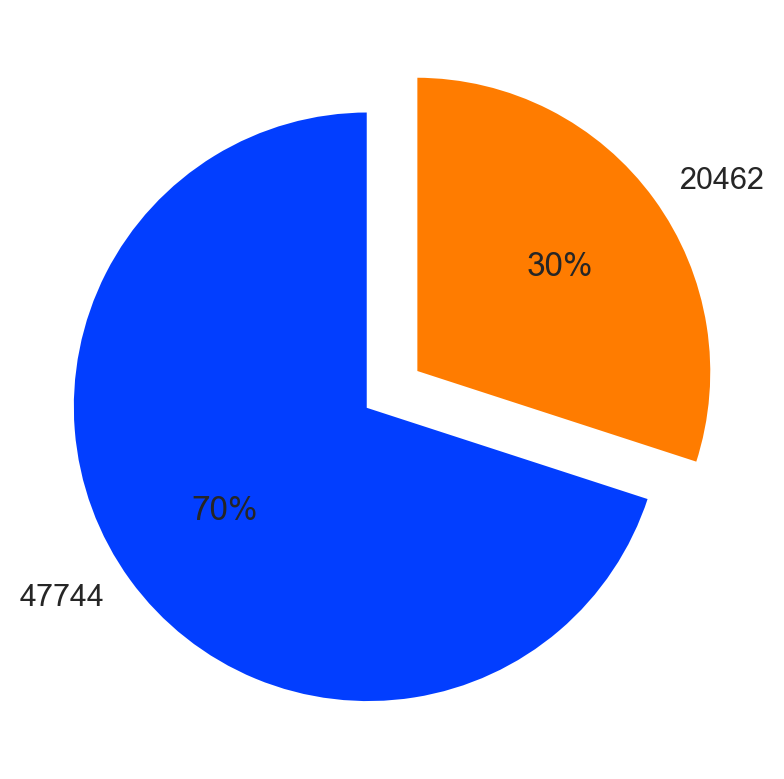

In [5]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y, random_state=100)
#define data
data = [X_train.shape[0],X_test.shape[0] ]
labels = [data[0], data[1]]
#define Seaborn color palette to use
colors = sns.color_palette('bright')[0:2]
#create pie chart
plt.pie(data, labels = labels, colors = colors,startangle=90, 
        autopct='%1.f%%',explode=(0.1,0.1))
plt.show()

Información del dataset:
 las clases del target son: Counter({0: 38914, 1: 8830})


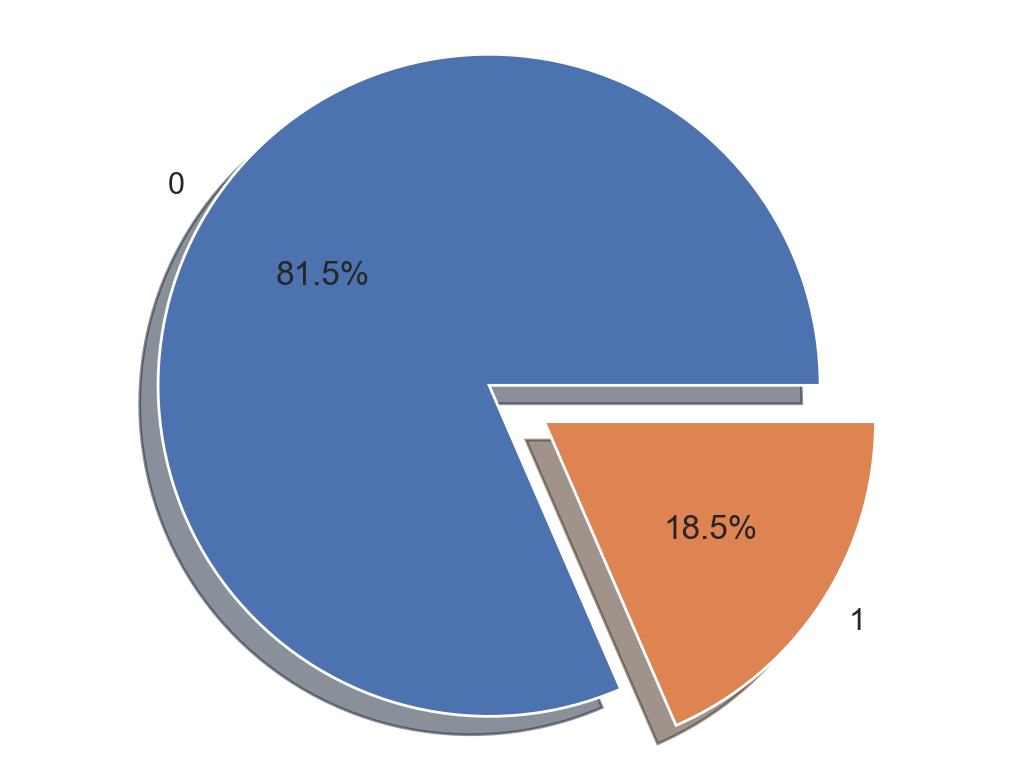

In [6]:
print('Información del dataset:'
      '\n las clases del target son: {}'.format(Counter(y_train)))
plot_pie(y_train)

In [7]:
col_to_drop = ['Fecha-O','Fecha-I','AÑO','Des-I','Vlo-I','Vlo-O','Ori-O','Ori-I','Des-I','OPERA','Emp-I',
                'IATA Code','Airport Name','Country','City/Town','ICAO Code','SIGLADES','SIGLAORI','Lat','Long','distance_to_destiny',
                'dif_min','fecha_operacion','temporada_alta','NVuelos-Ori-I','Nvuelos-Fecha-Emp-I','Nvuelos-Fecha-Emp-Des-I'
               ]

X_train.drop(columns=col_to_drop, inplace = True)
scaler = MinMaxScaler()
X_train.loc[:,['NVuelos-Ori-O','Nvuelos-Fecha-Emp-O','Nvuelos-Fecha-Emp-Des-O']] = scaler .fit_transform(X_train[['NVuelos-Ori-O',
                                                                                                                  'Nvuelos-Fecha-Emp-O','Nvuelos-Fecha-Emp-Des-O']])
X_test.drop(columns=col_to_drop, inplace = True)
X_test.loc[:,['NVuelos-Ori-O','Nvuelos-Fecha-Emp-O','Nvuelos-Fecha-Emp-Des-O']] = scaler.transform(X_test[['NVuelos-Ori-O',
                                                                                                           'Nvuelos-Fecha-Emp-O','Nvuelos-Fecha-Emp-Des-O']])
transformer = make_column_transformer(
    (OneHotEncoder(drop='first',sparse=False,handle_unknown='infrequent_if_exist'), ['Des-O','Emp-O','TIPOVUELO','periodo_dia','DIANOM','MES','DIA']),
    remainder='passthrough')

transformed = transformer.fit_transform(X_train)
transformed_x_train = pd.DataFrame(
    transformed, 
    columns=transformer.get_feature_names()
)
transformed = transformer.transform(X_test)
transformed_x_test = pd.DataFrame(
    transformed, 
    columns=transformer.get_feature_names()
)
transformed_x_test.head()

,onehotencoder__x0_EGLL,onehotencoder__x0_EGYP,onehotencoder__x0_KATL,onehotencoder__x0_KDFW,onehotencoder__x0_KIAH,onehotencoder__x0_KJFK,onehotencoder__x0_KLAX,onehotencoder__x0_KMCO,onehotencoder__x0_KMIA,onehotencoder__x0_LEMD,...,onehotencoder__x6_27,onehotencoder__x6_28,onehotencoder__x6_29,onehotencoder__x6_30,onehotencoder__x6_31,tipo_atraso,NVuelos-Ori-O,Nvuelos-Fecha-Emp-O,Nvuelos-Fecha-Emp-Des-O,Vlo-I_cambio
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,retraso crítico,0.711538,0.057971,0.090909,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,a tiempo,0.461538,0.086957,0.272727,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,a tiempo,0.557692,0.478261,0.727273,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,a tiempo,0.519231,0.550725,0.363636,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,a tiempo,0.798077,0.623188,0.090909,1


In [8]:
path = os.getcwd() + '/data/interim/model_data_train_ohe.csv' 
transformed_x_train.to_csv(path,
          sep=',',
          index = False
         )
path = os.getcwd() + '/data/interim/model_data_test_ohe.csv' 
transformed_x_test.to_csv(path,
          sep=',',
          index = False
         )
path = os.getcwd() + '/data/interim/y_train_ohe.csv' 
y_train.to_csv(path,
          sep=',',
          index = False
         )
path = os.getcwd() + '/data/interim/y_test_ohe.csv' 
y_test.to_csv(path,
          sep=',',
          index = False
         )